# <center>TP2</center>
# <center>Grupo 11</center>

#Integrantes:
- Blas Chuc - 110253
- Franco Rodriguez - 108799
- Helen Chen - 110195
- Tomas Caporaletti - 108598

##Importar librerías e instalar dependencias

In [8]:
#Gráficos
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#Descarga de modelos
from joblib import dump
import joblib

##Entrenamiento
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

##Modelos
from sklearn.ensemble import RandomForestClassifier
import torch
import collections
from collections import Counter, OrderedDict

##Metricas
from sklearn import metrics


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

##Metricas
from sklearn import metrics


##Para generar archivos de salida
from datetime import datetime
from zoneinfo import ZoneInfo

In [9]:
!pip install -q gdown

##Carga del dataset de trabajo

In [ ]:
!gdown --id 1KNzJ7RtqGMAQEEWZqrQ8G9j8yim1GNi1
!gdown --id 1eVXrJ4w7Gn6FZI7gl-GgucHTmw9105th

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KNzJ7RtqGMAQEEWZqrQ8G9j8yim1GNi1
To: /content/test.csv
100% 11.1M/11.1M [00:00<00:00, 38.8MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1eVXrJ4w7Gn6FZI7gl-GgucHTmw9105th
To: /content/train.csv
100% 72.2M/72.2M [00:01<00:00, 51.3MB/s]


In [ ]:
df_train = pd.read_csv('train.csv')

In [ ]:
df_test = pd.read_csv('test.csv')

##Analisis de los datos

### Visualización de algunos registros

In [ ]:
df_train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [ ]:
df_test.head()

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."


**Observación**: El dataset de train no posee información acerca de si una review es positiva o negativa.

###Información acerca de los datasets

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


El dataset de train contiene 50000 registros con opiniones, mientras que el de test cuenta con 8599. Ninguno de ellos posee valores nulos en ninguna de sus columnas.

In [ ]:
print(df_train['sentimiento'].isna().sum())

0


###Balance entre las categorías de sentimientos

El dataset de entrenamiento se encuentra perfectamente balanceado respecto a la variable target

In [ ]:
df_train['sentimiento'].value_counts()

,count
sentimiento,
positivo,25000
negativo,25000


/tmp/ipython-input-1881419352.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteos.index, y=conteos.values, palette=palette)


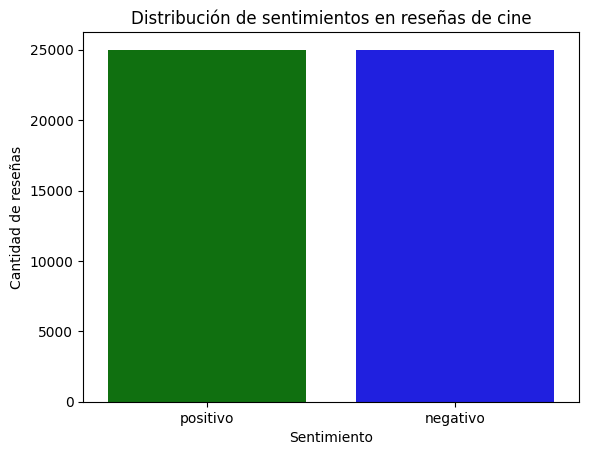

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

conteos = df_train['sentimiento'].value_counts()

# Colores por categoría
colores = {
    "positivo": "green",
    "negativo": "blue",
}

# Lista de colores en el mismo orden que los índices
palette = [colores.get(cat.lower(), "blue") for cat in conteos.index]

sns.barplot(x=conteos.index, y=conteos.values, palette=palette)
plt.title("Distribución de sentimientos en reseñas de cine")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de reseñas")
plt.xticks(rotation=0)
plt.show()

###Análisis del idioma real de las resenas. Están todas en Espanol como esperamos?

In [ ]:
!pip install langdetect

In [ ]:
from langdetect import detect

df_train_lang = df_train.copy()

# Detección del idioma de cada reseña:
df_train_lang['lang'] = df_train_lang['review_es'].apply(lambda x: detect(x))

# Filtrar reseñas que NO están en español
df_train_no_es = df_train_lang[df_train_lang['lang'] != 'es']

In [ ]:
count_no_es = len(df_train_no_es)
print("Cantidad de reseñas detectadas que NO están en español: ", count_no_es)

Cantidad de reseñas detectadas que NO están en español:  1819


In [ ]:
df_train_no_es.head()

,ID,review_es,sentimiento,lang
156,156,From the film's first shot - Keira Knightley a...,negativo,en
249,249,'Airport 4' is basically a slopped together me...,negativo,en
250,250,"Supposedly a ""social commentary"" on racism and...",negativo,en
263,263,"There is a difference between a ""film,"" and a ...",negativo,en
264,264,please re-watch all 3 series and do not go see...,negativo,en


In [ ]:
print("Idiomas detectados en la columna 'lang':")
# Lista de idiomas únicos
print(df_train_lang['lang'].unique())

print("\nCantidad de registros por idioma:")
# Conteo por idioma
print(df_train_lang['lang'].value_counts())

count_es = len(df_train_lang[df_train_lang['lang'] == 'es'])
print(f"\nNúmero de reseñas en español: {count_es}")
print(f"Número de reseñas en lenguaje distinto de español: {count_no_es}")

Idiomas detectados en la columna 'lang':
['es' 'en' 'id' 'it']

Cantidad de registros por idioma:
lang
es    48181
en     1817
id        1
it        1
Name: count, dtype: int64

Número de reseñas en español: 48181
Número de reseñas en lenguaje distinto de español: 1819


Se detectó que las reviews están en 4 idiomas distintos:

- Espanol (es)
- Inglés (en)
- Indonesio (id)
- Italiano (it)

A continuación analizamos si hubo falsos positivos en la detección de NO espanol.

In [ ]:
df_train_it = df_train_lang[df_train_lang['lang'] == 'it']
df_train_it.head()

,ID,review_es,sentimiento,lang
48927,48927,¡La justicia del episodio de Smallville es el ...,positivo,it


In [ ]:
print(df_train_it['review_es'].values.tolist())

['¡La justicia del episodio de Smallville es el mejor episodio de Smallville!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!¡Es mi episodio favorito de Smallville!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!']


La review detectado en idioma Italiano está en idioma Espanol, es un falso positivo.

In [ ]:
df_train_id = df_train_lang[df_train_lang['lang'] == 'id']
df_train_id.head()

,ID,review_es,sentimiento,lang
45315,45315,..... Whoops: parece que le va a costar una fr...,positivo,id


In [ ]:
print(df_train_id['review_es'].values.tolist())

['..... Whoops: parece que le va a costar una friolera de 198.00 para comprar una copia (ya sea en formato DVD o video) desde ITV direct.ouch.Sorry sobre esto, pero IMDB no me permitirá enviar este comentario a menos que seatiene al menos10 líneas, por lo...........blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah!!']


La review detectado en idioma Indonesio está en idioma Espanol, también es un falso positivo.

In [ ]:
df_train_en = df_train_lang[df_train_lang['lang'] == 'en']
df_train_en.head()

,ID,review_es,sentimiento,lang
156,156,From the film's first shot - Keira Knightley a...,negativo,en
249,249,'Airport 4' is basically a slopped together me...,negativo,en
250,250,"Supposedly a ""social commentary"" on racism and...",negativo,en
263,263,"There is a difference between a ""film,"" and a ...",negativo,en
264,264,please re-watch all 3 series and do not go see...,negativo,en


Las reviews que se detectaron en idioma Inglés efectivamente lo están de esa manera.

In [ ]:
# Porcentaje de resenas en inglés:

porcentaje_en = (len(df_train_en) / len(df_train)) * 100
print(f"El porcentaje de reseñas en inglés es: {porcentaje_en}%")

El porcentaje de reseñas en inglés es: 3.634%


##Preprocesamiento del dataset

###Preprocesamiento del dataset

Conversión de los valores de la columna `sentimiento` a binario.


*   'positivo' --> 1
*   'negativo' --> 0

In [ ]:
df_train['sentimiento'] = df_train['sentimiento'].map({'negativo': 0, 'positivo': 1})

# criticas_train = df_train['review_es'].values
# sentimientos_train = df_train['sentimiento']

Eliminamos las resenas en inglés. No van a aportar valor a nuestro análisis, y como vimos anteriormente son menos del 4% de las resenas totales.

In [ ]:
indices = df_train_en.index

print("Cantidad de registros totales:", len(df_train))
df_train = df_train.drop(indices)

print("Cantidad de registros totales totales en español:", len(df_train))

In [ ]:
# Guardo dataset preprocesado en su mismo formato
df_train = df_train.reset_index(drop=True)

df_train.to_csv('train_preprocesado.csv', index=False)

###Preprocesamiento de texto

In [ ]:
print("CELDA 3: Definiendo la función de preprocesamiento de texto (NLTK)...")

nltk.download('stopwords')

# Stemmer en español

stemmer = SnowballStemmer('spanish')

# Salvamos las negaciones
stop_words_es = set(stopwords.words('spanish'))
palabras_a_mantener = {'no', 'ni', 'sin', 'pero', 'nada', 'poco', 'muy', 'nunca', 'jamás'}
stop_words_es = stop_words_es - palabras_a_mantener

def preprocess_text_stem(text):
    # Convertir a minúsculas
    text = str(text).lower()

    # Eliminar HTML
    text = re.sub(r'<[^>]+>', ' ', text)

    # Eliminar caracteres especiales pero dejar letras y tildes
    text = re.sub(r'[^a-záéíóúñ\s]', '', text)

    words = text.split()

    # Aplicar Stemming y filtrar stopwords
    cleaned_words = [
        stemmer.stem(word)
        for word in words
        if word not in stop_words_es and len(word) > 1
    ]

    return ' '.join(cleaned_words)


CELDA 3: Definiendo la función de preprocesamiento de texto (NLTK)...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Carga del dataset pre-procesado

In [ ]:
# Carga del dataset pre-procesado
df = pd.read_csv('train_preprocesado.csv')
df_train = df.copy()

##Set de entrenamiento y test

Particionamos el dataset con entrenamiento 80% y test 20%. Utilizando stratify balanceamos la división según el target.

In [ ]:
X = df_train['review_es']
X = X.apply(preprocess_text_stem)

Y = df_train['sentimiento']

x_text_train, x_text_test, y_text_train, y_text_test = train_test_split(X,
                                                            Y,
                                                            test_size = 0.2,
                                                            random_state = 42,
                                                            stratify = Y
)

In [ ]:
# Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_text_train)))
print('# Datos Prueba: {}'.format(len(x_text_test)))

# Datos Entrenamiento: 38546
# Datos Prueba: 9637


Mostramos algunos registros de cada set

In [ ]:
x_text_train.head(2)

,review_es
34795,bas librement novel earl derr biggers seri cha...
436,rar necesari escrib reseñ siti per pelicul muy...


In [ ]:
y_text_train.head(2)

,sentimiento
34795,0
436,0


In [ ]:
x_text_test.head(2)

,review_es
16053,no acuerd cualqui person no gust peliculasol a...
47902,no dic muchoest pelicul killjoy mejor cinemato...


In [ ]:
y_text_test.head(2)

,sentimiento
16053,1
47902,0


##Bag of words

###Entrenamiento y Optimización del Vectorizador TF-IDF

In [ ]:
SEED = 42

In [ ]:
pipeline_rf_base = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=SEED))  # parámetros default
])

# Grid solo para el vectorizador
param_grid_tfidf = {
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [2, 5],
    'tfidf__max_df': [0.5, 0.7, 0.9],
    'tfidf__binary': [True, False],
    'tfidf__sublinear_tf': [True, False]
}

grid_tfidf = GridSearchCV(
    pipeline_rf_base,
    param_grid_tfidf,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)


In [ ]:
grid_tfidf.fit(x_text_train, y_text_train)
print("Mejores parámetros TF-IDF:", grid_tfidf.best_params_)

In [ ]:
print("Mejor F1 obtenido por TF-IDF:", grid_tfidf.best_score_)

Mejor F1 obtenido por TF-IDF: 0.842338185680438


In [ ]:
vectorizer_pre_entrenado = grid_tfidf.best_estimator_.named_steps["tfidf"]

###Carga del Vectorizador TF-IDF Preentrenado

La búsqueda de los mejores hiper parámetros para el Vectorizer TF-IDF llevó alrededor de 9 horas. Por lo que cargarlo ya prentrenado, resultado de esa larga ejecución, es una buena opción para continuar.

In [5]:
!gdown --id 1pojnixlayg3_Dg5LiA1V9uArVeH6Iz-w

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pojnixlayg3_Dg5LiA1V9uArVeH6Iz-w
From (redirected): https://drive.google.com/uc?id=1pojnixlayg3_Dg5LiA1V9uArVeH6Iz-w&confirm=t&uuid=f7760d63-ffd4-42b3-8a99-4e29948cad07
To: /content/vectorizador_tfidf_rf.pkl
100% 154M/154M [00:01<00:00, 95.2MB/s]


In [10]:
grid_obj = joblib.load("vectorizador_tfidf_rf.pkl")
vectorizer_pre_entrenado = grid_obj.best_estimator_.named_steps["tfidf"]

# Evita que se re-entrene
vectorizer_pre_entrenado.fixed_vocabulary_ = True


In [ ]:
print("Mejores parámetros TF-IDF:", grid_obj.best_params_)

Mejores parámetros TF-IDF: {'tfidf__binary': False, 'tfidf__max_df': 0.5, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3), 'tfidf__sublinear_tf': True}


##Random Forest

###Búsqueda de hiper-parámetros

In [ ]:
SEED = 42

In [ ]:
# 1. Pipeline
pipeline_rf = Pipeline([
    ('tfidf', vectorizer_pre_entrenado),
    ('rf', RandomForestClassifier(random_state=SEED))
])

# 2. Grid
param_grid_rf = {
    'rf__criterion': ['gini'],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_split': [5, 10],
    'rf__min_samples_leaf': [2, 4, 6],
    'rf__max_features': ['sqrt']
}

# 3. Configuración de la búsqueda
grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

Entrenamiento:

In [ ]:
grid_rf_fit = grid_rf.fit(x_text_train, y_text_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [ ]:
modelo_rf = grid_rf_fit.best_estimator_

Mejores hiperparámetros del modelo

In [ ]:
print(grid_rf_fit.best_params_)

{'rf__criterion': 'gini', 'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 300}


###Carga del Random Forest preentrenado

El modelo cargado a continuación fue el resultante del entrenamiento de la sección previa.

In [ ]:
!gdown --id 1ZEjfjsY2f1qtVYmY1t4wCIhJ1WuiS95C

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZEjfjsY2f1qtVYmY1t4wCIhJ1WuiS95C
To: /content/Random_Forest.pkl
100% 12.9M/12.9M [00:00<00:00, 32.3MB/s]


In [ ]:
modelo_rf = joblib.load("Random_Forest.pkl")

###Evaluación del modelo en TRAIN y TEST

In [ ]:
# TEST
y_rf_test_pred = modelo_rf.predict(x_text_test)

# TRAIN
y_rf_train_pred = modelo_rf.predict(x_text_train)

##### Métricas obtenidas

Matrices de confusión

Text(0.5, 1.0, 'Matriz de confusión sobre TEST')

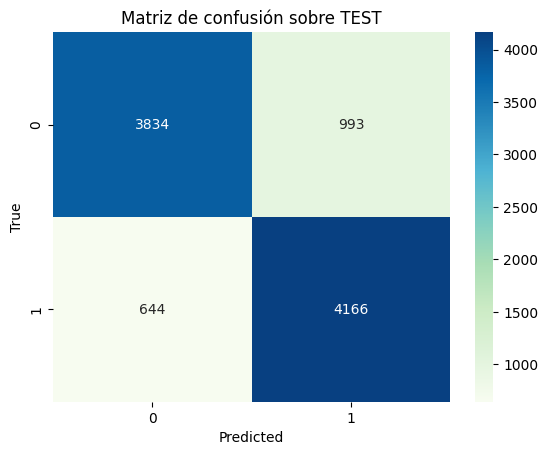

In [ ]:
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, classification_report

# Creo la matriz de confusión
tabla = confusion_matrix(y_text_test, y_rf_test_pred)

# La grafico
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Matriz de confusión sobre TEST")

Text(0.5, 1.0, 'Matriz de confusión sobre TRAIN')

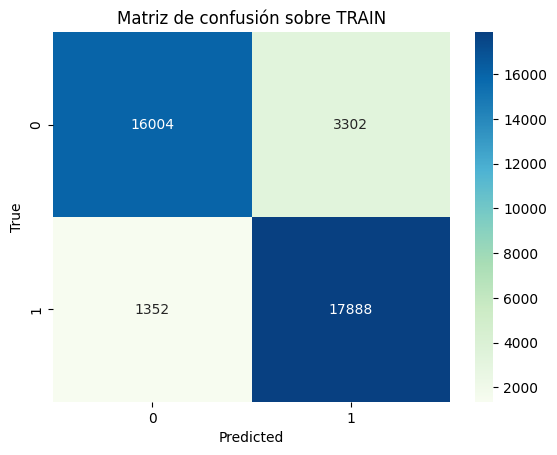

In [ ]:
# Creo la matriz de confusión
tabla = confusion_matrix(y_text_train, y_rf_train_pred)

# La grafico
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Matriz de confusión sobre TRAIN")

Curva ROC

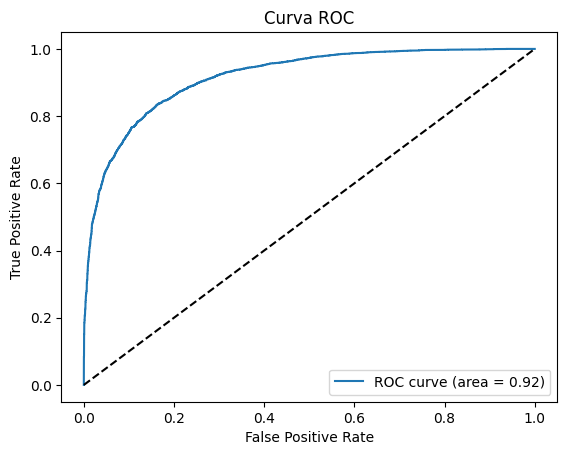

In [ ]:
from sklearn.metrics import roc_curve, auc

y_proba = modelo_rf.predict_proba(x_text_test)[:, 1]
fpr, tpr, _ = roc_curve(y_text_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Reportes

In [ ]:
from sklearn.metrics import classification_report

print("🔹 Métricas en TRAIN:")
print(classification_report(y_text_train, y_rf_train_pred, digits=3))

print("🔹 Métricas en TEST:")
print(classification_report(y_text_test, y_rf_test_pred, digits=3))

🔹 Métricas en TRAIN:
              precision    recall  f1-score   support

           0      0.922     0.829     0.873     19306
           1      0.844     0.930     0.885     19240

    accuracy                          0.879     38546
   macro avg      0.883     0.879     0.879     38546
weighted avg      0.883     0.879     0.879     38546

🔹 Métricas en TEST:
              precision    recall  f1-score   support

           0      0.856     0.794     0.824      4827
           1      0.808     0.866     0.836      4810

    accuracy                          0.830      9637
   macro avg      0.832     0.830     0.830      9637
weighted avg      0.832     0.830     0.830      9637



##### Guardo el modelo

In [ ]:
import joblib

joblib.dump(modelo_rf, "Random_Forest.pkl")

from google.colab import files
files.download("Random_Forest.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Solución

In [ ]:
pred_test_rf = modelo_rf.predict(df_test['review_es'])

In [ ]:
def save_prediction(pred_test, file_name):
  ids = df_test['ID'].values.tolist()
  sent_pred = ['positivo' if p == 1 else 'negativo' for p in pred_test]

  df_exportar = pd.DataFrame({
    "ID": ids,
    "sentimiento": sent_pred
  })

  df_exportar.to_csv(f"{file_name}.csv", index=False, encoding="utf-8")

In [ ]:
def filename_generator(base_name):
    now = datetime.now(ZoneInfo("America/Argentina/Buenos_Aires"))
    ts = now.strftime("%d-%m-%Y_%H-%M")
    return f"{base_name}_{ts}"

In [ ]:
# Random Forest
file_name = filename_generator("random_forest")
save_prediction(pred_test_rf, file_name)